# Comment Data Cleaning and Preliminary Analysis

### Team Name: Team 3
### Team Members: Wen Yi Aw, Walker Azam, Ken Masumoto

One of our research questions for this project is "What are the qualitites of 'good' advice on career advice subreddits?" To answer this question, we need to analyze the comments on the submissions from our chosen subreddits. We start by importing the necessary libraries and reading in the comment data CSVs from Phase 1.

### Contributions

- Walker: Topic modeling analysis
- Wen Yi: More submission data collection + Comment data analysis
- Ken: Comment data cleaning and analysis

## Part 1: Cleaning

We start the cleaning process by importing the necessary libraries and reading in our csv file containing our comment data.

In [4]:
# import necessary packages
import pandas as pd
import re, string

In [5]:
# load data
ask_HR_comments = pd.read_csv("askHR_comments.csv", lineterminator='\n')
career_guidance_comments = pd.read_csv("careerguidance_comments.csv", lineterminator='\n')

# join data files
comments = pd.concat([ask_HR_comments, career_guidance_comments])

In [6]:
# data preview
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN


Next, we can run the comment bodies through a preliminary cleaning process, removing links, digits, and punctuation.

In [7]:
def clean1(text):
    """
    Given a text string, removes capitalization, links, numbers, and punctuation. Returns cleaned text string.
    """
    text = text.lower() # make all text to lowercase
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', text) # remove all links
    text = re.sub('\w*\d\w*', '', text) # remove all digits and words containing numbers
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation marks
    text = re.sub('[^A-Za-z ]+', '', text) #remove non-alphabetic characters
    return text

# function to apply clean1 to all entries
cleaner1 = lambda x: clean1(x)

In [8]:
# clean comment body text
comments['cleaned_body'] = pd.DataFrame(comments['body'].apply(cleaner1))

In [9]:
# show cleaned text
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happy for you side note but damn they didnt e...
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,my boss came in a few weeks ago bitching about...
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,let us know how they respond when you give not...
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,did they let you go either way these people ar...
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratulations after you have spent a few m...


Next, we can run the comments' text bodies through an additional round of cleaning by removing the stopwords and stemming each word.

In [10]:
# import necessary packages for stopwords, stemming, tokenizing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# set stopword language
stopeng = set(stopwords.words('english'))
ps = PorterStemmer()

In [11]:
def removeStopAndStem(text):
    """
    Given a text string, removes stopwords and converts words to stems, then returns as one string.
    """
    tokens = word_tokenize(text) # tokenize text
    tokens_nostop = [w for w in tokens if w not in stopeng] # remove stopwords
    tokens_stemmed = [ps.stem(w) for w in tokens_nostop if w != ps.stem(w)] # replace tokens with stems
    text_nostop_stemmed = " ".join([word for word in tokens_stemmed]) # join back to sentence form
    return text_nostop_stemmed

# function to apply removeStopAndStem to all entries
stopRemoverAndStemmer = lambda x: removeStopAndStem(x)

In [12]:
# remove stopwords, then stem comment body text
comments['cleaned_body'] = pd.DataFrame(comments['cleaned_body'].apply(stopRemoverAndStemmer))

In [13]:
# display data
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...


## Part 2: Preliminary Analysis

Now that we have a cleaned, stemmed, and stopword-free version of the comment bodies, we can start to perform some of the analysis on this text. For this preliminary analysis, we decided to collect the following attributes of each comment body:
- Sentiment score (VADER and TextBlob)
- Ratio of stopwords
- Length of post
- Readbility score (Gunning-Fog and Smog)

### Sentiment Score Calculation

We chose to measure sentiment for the comments using VADER and TextBlob. We start by importing the libraries necessary to perform this analysis.

In [14]:
# import packages for sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Then we can save the TextBlob scorer in a lambda function and apply it to all the cleaned rows in the dataframe.

In [15]:
def TextBlobSent(text):
    """
    Given a text string, returns polarity of the text, scored by TextBlob.
    """
    blob = TextBlob(text)
    return blob.polarity

# function to apply TextBlobSent to all entries
TextBlobSentimentizer = lambda x: TextBlobSent(x)

In [16]:
# score cleaned comment text on polarity
comments['TextBlob'] = pd.DataFrame(comments['cleaned_body'].apply(TextBlobSentimentizer))

We can also add a column to the dataframe that categorizes the comments as "positive," "negative," or "neutral" depending on the TextBlob sentiment score. We know that VADER uses the following thresholds, so we will use the same for the TextBlob scores to control for as much as we can (and because they use the same scale).

- Negative: Score <= -0.05
- Neutral: -0.05 < Score < 0.05
- Positive: Score >= 0.05

In [17]:
def overallScore(compoundscore):
    """
    Given polarity score, returns "positive", "negative", or "neutral" based on the sign of the score
    (with 0.05 buffer).
    """
    if compoundscore > 0.05:
        return "positive"
    elif compoundscore < -0.05:
        return "negative"
    else:
        return "neutral"

# function to apply overallScore to all entries
overallScorer = lambda x: overallScore(x)

In [18]:
# calculate sentiment category of TextBlob scores and store in new column
comments['TextBlob_Category'] = pd.DataFrame(comments['TextBlob'].apply(overallScorer))

We can also do the exact same process, except with the VADER scores this time.

In [19]:
# initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

def VADERSent(text):
    """
    Given text string, returns compound polarity score, calculated using VADER sentiment analysis.
    """
    return analyzer.polarity_scores(text)['compound']

# function to apply VADERSent to all entries
VADERSentimentizer = lambda x: VADERSent(x)

In [20]:
# calculate VADER polarity score of each comment and store in new column
comments['VADER'] = pd.DataFrame(comments['cleaned_body'].apply(VADERSentimentizer))

In [21]:
# calculate sentiment category of VADER scores and store in new column
comments['VADER_Category'] = pd.DataFrame(comments['VADER'].apply(overallScorer))

And now we can verify that everything has been added correctly.

In [22]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.000000,neutral,0.0000,neutral
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,0.136364,positive,-0.7184,negative
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.0000,neutral
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,-0.5106,negative
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,-0.125000,negative,0.3612,positive


### Ratio of Stopwords and Length of Post

To find the ratio of stopwords in the post, we have to work with the original body instead of the cleaned body, because the cleaned body has all of the stopwords already removed. We can do this by creating a function that takes in the body of the comment and divides the number of stopwords by the total number of words, then saving this as a lambda function and applying it to all of the rows, as we did with the sentiment analysis above.

In [23]:
def stopwordRatio(text):
    """
    Given text string, returns the ratio of English stopwords to total word count.
    """
    tokens = word_tokenize(text)
    total_words = len(tokens)
    total_stopwords = 0
    # count stopwords
    for token in tokens:
        if token in stopeng:
            total_stopwords += 1
    return total_stopwords / total_words

# function to apply stopwordRatioFinder to all entries
stopwordRatioFinder = lambda x: stopwordRatio(x)

In [24]:
# calculate stopword ratio of each comment and store in new column
comments['stopword_ratio'] = pd.DataFrame(comments['body'].apply(stopwordRatioFinder))

And we can verify that this column has been added correctly.

In [25]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.000000,neutral,0.0000,neutral,0.414634
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,0.136364,positive,-0.7184,negative,0.318182
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.0000,neutral,0.307692
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,-0.5106,negative,0.379310
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,-0.125000,negative,0.3612,positive,0.365079


Finding the length of the post is also a very similar process, but instead, we just return the total number of words in the text. Again, we will work with the original body for this.

In [26]:
def textLength(text):
    """
    Given text string, returns word count.
    """
    tokens = word_tokenize(text)
    return len(tokens)

# function to apply textLengthFinder to all entries
textLengthFinder = lambda x: textLength(x)

In [27]:
# calculate stopword ratio of each comment and store in new column
comments['body_length'] = pd.DataFrame(comments['body'].apply(textLengthFinder))

And again, we can verify that this was added correctly.

In [28]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.000000,neutral,0.0000,neutral,0.414634,41
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,0.136364,positive,-0.7184,negative,0.318182,44
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.0000,neutral,0.307692,13
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,-0.5106,negative,0.379310,29
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,-0.125000,negative,0.3612,positive,0.365079,63


### Readability Scores

The final variable we chose to include for this part of the analysis was readability scores. We will use the both Gunning-Fog and the Smog Readability Index scores to measure the readability of each comment. Again, we will use the original body for this analysis, as the cleaned body is nonsensical with the stopwords removed and the words stemmed.

In [29]:
import textstat

In [30]:
def smog(text):
    """
    Given text string, returns SMOG readability grade.
    """
    return textstat.smog_index(text)

# function to apply smog calculation function to all entries
smog_finder = lambda x: smog(x)

In [31]:
# calculate SMOG grade of each comment and store in new column
comments['smog_score'] = pd.DataFrame(comments['body'].apply(smog_finder))

In [32]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.000000,neutral,0.0000,neutral,0.414634,41,7.8
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,0.136364,positive,-0.7184,negative,0.318182,44,7.8
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.0000,neutral,0.307692,13,0.0
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,-0.5106,negative,0.379310,29,7.8
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,-0.125000,negative,0.3612,positive,0.365079,63,8.8


In [33]:
def gunning_fog(text):
    """
    Given text string, returns Gunning-Fog readability score.
    """
    return textstat.gunning_fog(text)

# function to apply gunning_fog_finder to all entries
gunning_fog_finder = lambda x: gunning_fog(x)

In [34]:
# calculate Gunning Fog score of each comment and store in new column
comments['gunning_fog_score'] = pd.DataFrame(comments['body'].apply(gunning_fog_finder))

And of course, we can verify that these columns have been added correctly!

In [35]:
comments.head()

,Unnamed: 0,submission id,comment id,body,score,is_submitter,distinguished,cleaned_body,TextBlob,TextBlob_Category,VADER,VADER_Category,stopword_ratio,body_length,smog_score,gunning_fog_score
0,0,r0mlaq,hltcpsw,"Happy for you. Side note but damn, they didn'...",243,False,NaN,happi theyr go realli awaken tri backfil,0.000000,neutral,0.0000,neutral,0.414634,41,7.8,5.82
1,1,r0mlaq,hltku5i,My boss came in a few weeks ago bitching about...,190,False,NaN,week bitch expens everyth get ask get live rai...,0.136364,positive,-0.7184,negative,0.318182,44,7.8,6.23
2,2,r0mlaq,hlti2pf,Let us know how they respond when you give not...,53,False,NaN,notic pleas,0.000000,neutral,0.0000,neutral,0.307692,13,0.0,4.40
3,3,r0mlaq,hltdpvt,"Did they let you go? Either way, these people ...",32,False,NaN,peopl idiot manag think peopl employ,-0.800000,negative,-0.5106,negative,0.379310,29,7.8,6.52
4,4,r0mlaq,hlu2q2d,Congratulations!! After you have spent a few...,15,False,NaN,congratul month get comfort settl pleas abl co...,-0.125000,negative,0.3612,positive,0.365079,63,8.8,7.51


## Part 3: Preliminary Visualization and Analysis

We now have a large number of categories to be able analyze to try to find what constitutes "good" advice on advice-giving subreddits. We use the comment score as the measure of "good" advice on the subreddits, and can find correlations between the comment score and the variables of interest. We can easily visualize these correlations using a heat map.

In [36]:
# import visualization libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns

Text(0.5, 1, 'Heatmap of Comment Data')

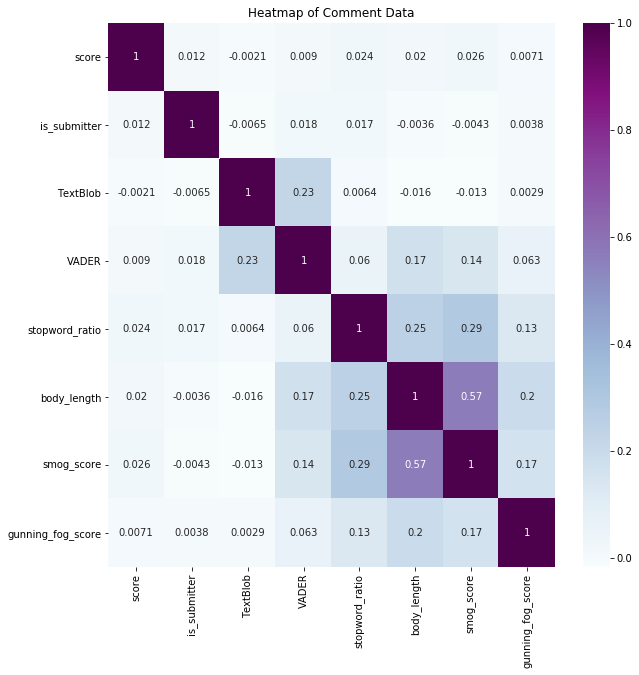

In [54]:
f, ax = plt.subplots(figsize=(10, 10))
# heatmap of correlation between variables
sns.heatmap(comments.drop(['distinguished', 'Unnamed: 0'], axis=1).corr(), ax=ax, annot=True, cmap="BuPu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.title('Heatmap of Comment Data')

Unfortunately, it does not look like any of the correlations between any of the variables and the comment score are particularly strong. However, this is just a preliminary analysis, so we can revisit this later to try to find any stronger relationships.

We can also start to visualize the distributions of some of the variables that we just discovered, to get an overall better understanding of the data.

Text(0.5, 0, 'Upvotes')

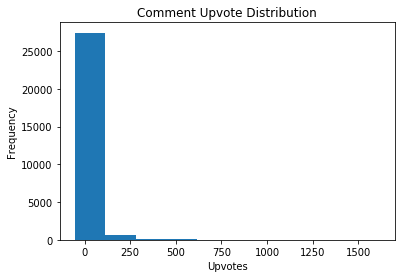

In [68]:
# histogram of upvotes
comments['score'].plot.hist()
plt.title("Comment Upvote Distribution")
plt.xlabel("Upvotes")

This isn't particularly useful, so we will instead graph the histogram of scores under 200.

Text(0.5, 0, 'Score')

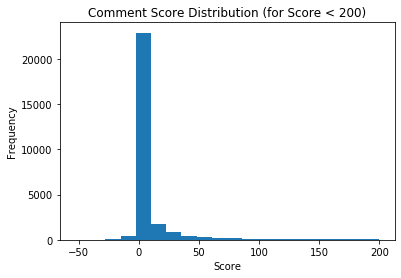

In [66]:
# histogram of upvotes for comments with less than 200 upvotes
comments[comments['score'] <= 200].score.plot.hist(bins=20)
plt.title("Comment Score Distribution (for Score < 200)")
plt.xlabel("Score")

We can see that the scores are relatively normally distributed, with the vast majority of scores being close to 0.

Text(0.5, 0, 'Polarity')

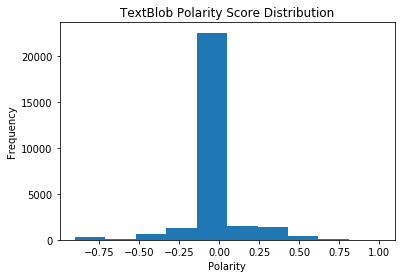

In [40]:
# histogram of TextBlob polarity scores
comments['TextBlob'].plot.hist()
plt.title("TextBlob Polarity Score Distribution")
plt.xlabel("Polarity")

Text(0.5, 0, 'Polarity')

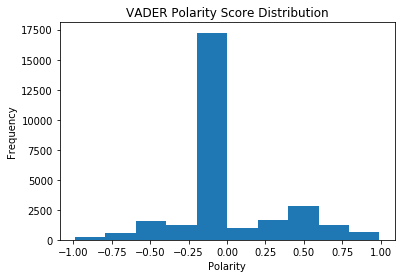

In [41]:
# histogram of VADER polarity scores
comments['VADER'].plot.hist()
plt.title("VADER Polarity Score Distribution")
plt.xlabel("Polarity")

The two sentiment analysis score histograms also give some interesting results. They both center around 0, which makes sense. However, the VADER scores seem to be bimodal (or even trimodal), with additional apexes at -0.5 and 0.5. This may be just the way that VADER tends to score sentiments, or it could be something to delve deeper into. This is something we will explore further in future phases.

Text(0.5, 0, '# stopwords / total words')

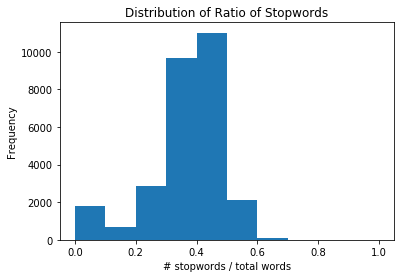

In [42]:
# histogram of stopword ratios
comments['stopword_ratio'].plot.hist()
plt.title("Distribution of Ratio of Stopwords")
plt.xlabel("# stopwords / total words")

The stopword ratio histogram looks relatively normally distributed around 0.4. There isn't much to analyze here, especially since the correlation between stopword ratio and comment score was relatively low.

Text(0.5, 0, 'Word Count')

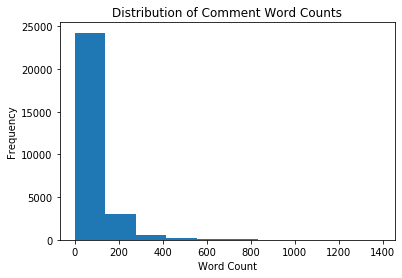

In [43]:
# histogram of comment length
comments['body_length'].plot.hist()
plt.title("Distribution of Comment Word Counts")
plt.xlabel("Word Count")

Text(0.5, 0, 'Word Count')

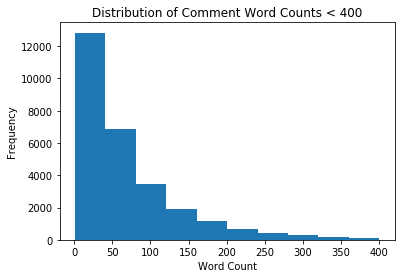

In [44]:
# histogram of comment length, for comments with less than 400 words
comments[comments['body_length']  <= 400].body_length.plot.hist()
plt.title("Distribution of Comment Word Counts < 400")
plt.xlabel("Word Count")

The distribution of comments with word counts is an interesting graph because it is almost a perfect right-skewed distribution. We can see that most of the comments were relatively short, but some were much longer.

Text(0.5, 0, 'SMOG Score')

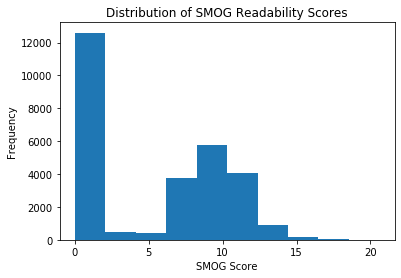

In [45]:
# histogram of SMOG readability scores
comments['smog_score'].plot.hist()
plt.title("Distribution of SMOG Readability Scores")
plt.xlabel("SMOG Score")

Text(0.5, 0, 'Gunning-Fog Score')

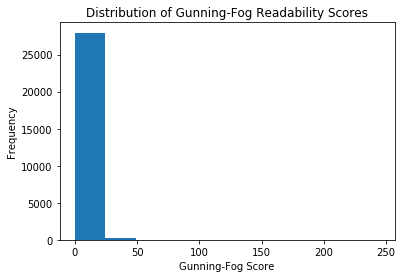

In [46]:
# histogram of Gunning-Fog readability scores
comments['gunning_fog_score'].plot.hist()
plt.title("Distribution of Gunning-Fog Readability Scores")
plt.xlabel("Gunning-Fog Score")

Text(0.5, 0, 'Gunning-Fog Score')

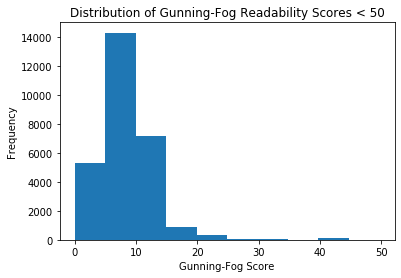

In [47]:
# histogram of Gunning-Fog readability scores under 50
comments[comments['gunning_fog_score'] <= 50].gunning_fog_score.plot.hist()
plt.title("Distribution of Gunning-Fog Readability Scores < 50")
plt.xlabel("Gunning-Fog Score")

For the readability scores, the Gunning-Fog score is somewhat right skewed, with a peak in the range of 5-10 (i.e. a reading level for U.S. grades 5-10). The SMOG score seems at first glance to be more interesting, but this is likely just the way that the Smog score is calculated. It is likely that there is a normal distribution around 8 or 9 (i.e. a reading level for U.S. grades 8-9), with a handful of comments being given a score of 0 because SMOG couldn't accurately score it. This will be something we will look into in future phases, though, just to make sure.

## Part 4: Conclusions

It was a little bit disappointing to not find any strong correlations between the comment score and the other variables, but in future phases we can still find new variables to compare and also look more deeply into the relationships than a correlation test will allow. However, we did still learn a lot about our data set, which we can iterate on for future phases.